# Tarea 2 - Compresión de imágenes usando PCA

### Alejandra Solís Sala

En la presente tarea, veremos una aplicación de PCA para compresión de imágenes. 

Se trabaja con un conjunto de 10 imágenes para hacer la matriz de transformación. Las imágenes son rostros de famosos que se tomaron de forma aleatoria de internet. El conjunto de prueba para la compresión está formado por tres imágenes, todas png. 

Se presenta primero las funciones auxiliares y al final se engloban para hacer la compresión.

In [10]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
  
# Localización de las imágenes

# Comentario: Esta no es la forma más eficaz de abrir el conjunto de imágenes
# Idealmente las tenía con nombres de números y hacía un for para guardar 
# los nombres, pero como solo son 10, lo hicimos de esta forma
dirs =['images/alexandra.jpg', 'images/amanda.jpg', 'images/anne.jpg',
       'images/emily.jpg', 'images/henry.jpeg', 'images/kate.jpg', 
       'images/lena.png', 'images/leonardo.jpg', 'images/mat.jpg', 
       'images/oscar.jpeg']

In [11]:
# Creación del conjunto de imágenes

Images = []
for file in dirs:
    Images.append(mpimg.imread(file))
    #plt.imshow(img)
    #print(img.shape)
Images = np.array(Images)

## Creación de parches

Lo primero que se hace es considerar el conjunto de imágenes para la construcción de las matrices de transformación. De éstas se sacan m parches de forma aleatoria: Se escoge aleatoriamente una imagen del conjunto y también el canal del que se extrae el parche. Todos los parches se usan posteriormente para crear 
la matriz $X$ de parches concatenados por los renglones.

In [12]:
# Funciones para creación de parches de imágenes

def get_random_crop(img, height, width):
    ''' Función para crear los cortes aletorios de las 
    imágenes. 
    
    Selecciona de forma aleatoria el canal de la imagen
    Regresa la imagen
    
    image: Imagen a cortar
    crop_height, crop_width: Dimensiones del corte
    '''
    
    # se verifica las dimensiones máximas para que el corte
    # no exceda las dimensiones de la imagen
    max_y = img.shape[0] - height
    max_x = img.shape[1] - width

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)
    

    canal = np.random.randint(0,3)

    parche = img[y: y + height, x: x + width, canal]

    return parche

def get_subimg(Images, m, l):
    '''Función para seleccionar las subimágenes aleatorias
    de un conjunto de imágenes.
    
    Se escoge de forma aleatoria la imagen del conjunto.
    
    Se regresa el vector de las imágenes
    
    Images: Conjunto de imágenes
    m: Número de parches
    l: Tamaño de la subimagen cuadrada'''
    
    subimgs = []
    n = len(Images)
    
    for i in range(m):
        # Se selecciona de forma aleatoria la imagen de la que
        # se tomará el parche
        im_index = np.random.randint(0, n)
        sub = get_random_crop(Images[im_index], l, l)
        subimgs.append(sub)
        
    return np.array(subimgs)

def create_matX(subs):
    '''Se crea la matriz X de las imágenes con renglones
    concatenados 
    
    subs: parches seleccionados del conjunto'''
    
    # Se concatenan las matrices de parches por sus renglones
    # y se crea la matriz X
    n = len(subs)
    X = []
    for i in range(n):
        X.append(subs[i])
        X[i] = X[i].ravel()
    return np.array(X)

## PCA

Se hace la función para obtener los componentes principales de la matriz X que contiene los parches. En este caso no se pide una varianza deseada, eso lo consideramos después.

Para hacer PCA usamos la matriz, ahora centrada, $X$, y hacemos el producto $X^T X$, en este caso no normalizamos la matriz, solo centramos.

Se regresan los valores propios y la matriz U de vectores propios.

In [13]:
# Función de las notas para imprimir

def printArray(X, precision=3, suppress = True):
    printOptionsOld = np.get_printoptions()
    np.set_printoptions(precision=precision, suppress=suppress)      
    print(X)
    np.set_printoptions(**printOptionsOld)

# Función para el PCA

def pca(X, Print = True):
    '''Dada una matriz centramos los datos y calculamos 
    los componentes principales
    '''
    
    # Se centran los datos
    X = X - np.mean(X, axis=0)
    #X = X / np.std(X, axis=0)
    
    # se saca la matriz de covarianza    
    corrMat = X.T.dot(X)
    
    if Print:
        print("\nMatriz de covarianza:\n")
        printArray(corrMat)

    evals, evecs = np.linalg.eigh(corrMat)
    
    # ordenando los eigenvalores de mayor a menor 
    
    idx = np.argsort(evals)[::-1]   
    evecsSorted = evecs[:,idx]      
    evalsSorted = evals[idx]        

    return evalsSorted, evecsSorted

## Creación de la matriz de trasnformación

En esta parte obtenemos los componentes principales de $X$ y lo usamos para generar la matriz $U$ de transformación hasta obtener la varianza deseada. 

Notemos que esta función puede ser una sola con PCA pero decidimos separarlo. 

In [14]:
# Función para la creación de matrices

def trans_mat(X, theta = 1, Print = True):
    '''Función para crear U_tilde
    
    X: matriz de datos centrados
    var: varianza deseada
    theta: fracción para seleccionar k eigenvectores'''
    
    # Obtenemos los componentes principales de X
    egvals, evecs = pca(X, Print)
    
    # Se reduce la matriz hasta llegar a la varianza theta deseada
    varianzaAcumulada = np.cumsum(egvals)/np.sum(egvals)
    
    indexVar = np.argmax(varianzaAcumulada >= theta)
    
    U = evecs[:,:indexVar+1]
    
    if Print:
        print("\nCantidad de eigenvectores tomados:\n")
        print(indexVar)

        print("\nMatriz de transformación:\n")
        printArray(U)
    
    return U

## Coeficientes $\beta$ y reconstrucción de la imagen

Una vez tengamos la matriz de transformación, podemos trabajar con imágenes adicionales para proyectar los renglones a un espacio de menor dimensión y luego volver a proyectarlos para reconstruir. En este caso consideramos una imagen y sacamos parches de igual tamaño y no sobrelapados de ella. Se puede ver esto como formar una cuadrícula de la imagen. Con los parches se forma una matriz $X$ como se hizo antes y la usamos para proyectar los datos usando la matriz $U$ de tranasformaciones.

La primera función se encarga de calcular $\beta = (U^{T}X^{T})^{T}$, la segunda se encarga de reconstruir la imagen una vez hayamos proyectado, lo hace de la siguiente manera: $\hat{X} = U \beta^{T}$. La última función es la que nos genera los parches, por canal, de la imagen nueva.

In [15]:
# Funciones para reconstruir imágenes

def coefs_beta(U, X):
    '''Calcula los coeficientes beta para una imagen
    
    U: matriz de transformación
    X: matriz de parches como renglones'''
    
    beta = np.dot(U.T, X.T).T
        
    return np.array(beta)

def reconstruccion(U, beta, coords, dim):
    '''Reconstruye las imágenes comprimidas
    
    U: matriz de transformación
    coords: vector de cooridenadas para saber dónde
            posicionar a los parches
    dim: dimensión de la imagen original'''
        
    m, k = beta.shape
    
    dim1, dim2 = dim
    
    X_rec = np.dot(U, beta.T)
    
    img = np.zeros(shape=(dim1,dim2), dtype = float)
    
    for i in range(m):
        aux = X_rec[:,i]
        l = int(np.sqrt(len(aux)))
        aux = aux.reshape((l,l))
        img[coords[i][0]:coords[i][0]+l, coords[i][1]:coords[i][1]+l] = aux
        
    return img

In [16]:
# Función para partir el conjunto de evaluación

def crop_equal(img, height, width):
    '''Función para cortar toda una imagen en parches iguales
    que no se traslapan. Considera solo imágenes cuadradas 
    
    Regresa una matriz por canal y las coordenadas de los parches
    '''
    
    parches_R = []
    parches_G = []
    parches_B = []
    coords = []
    
    dim = img.shape[0]

    # Se avanza en múltiplicos de las longtudes deseadas para tomar parches
    # no sobrelapados
    for j in range(0, dim, width):
        for i in range(0, dim, height):
            parches_R.append(img[i:i+height,j:j+width,0])
            parches_G.append(img[i:i+height,j:j+width,1])
            parches_B.append(img[i:i+height,j:j+width,2])
            coords.append([i,j])
            
    return np.array(parches_R), np.array(parches_G), np.array(parches_B), np.array(coords)

## Funciones para la compresión

En este apartado mostramos dos funciones, la primera engloba tres funciones para que, dado un conjunto de imágenes, nos regrese la matriz $X$ de parches concatenados, y la matriz de transformación $U$ a partir de la varianza deseada.

La segunda función sirve para comprimir una imagen. El proceso que sigue es el siguiente:

  1. Dada una imagen, obtiene la cuadrícula (parches) para generar su matriz $X$. Estos parches se hacen por
     canal, es decir, tenemos una matriz por canal. 
  2. Una vez tengamos las matrices, usamos la matriz $U$ previamente dada para proyectar los datos y obtener 
     así los coeficientes $\beta$.
  3. Con lo encntrado en el punto anterior, reconstruimos la imagen dada y se regresa. 

In [17]:
# Funciones que engloban las anteriores para crear matriz de transformaciones
# y para comprimir una imagen dada

def mat_trans(I, m, l, theta, Print = True):
    '''Regresa la matriz de transformación U_tilde
    
    I: Conjunto de imágenes
    m: Número de parches
    l: dim de los parches
    var: varianza para el pca
    theta: fracción para elegir eigenvectores
    '''
    
    subimages = get_subimg(I, m, l)
    
    X = create_matX(subimages)
    
    U = trans_mat(X, theta, Print)
        
    return X, U
    

def compresion(img, l, U, dim, Print = True):
    '''Comprime una imagen de 3 canales usando parches de tamaño l
    y las matrices X de los parches y U de transformación'''
    
    R, G, B, coords = crop_equal(img, l, l)
    R = create_matX(R)
    G = create_matX(G)
    B = create_matX(B)
    
    beta_R = coefs_beta(U, R)
    beta_G = coefs_beta(U, G)
    beta_B = coefs_beta(U, B)
    
    if Print:
        print("\nDatos proyectados para canal R:\n")
        printArray(beta_R)

        print("\nDatos proyectados para canal G:\n")
        printArray(beta_G)

        print("\nDatos proyectados para canal B:\n")
        printArray(beta_B)
    
    R = reconstruccion(U, beta_R, coords, dim)
    G = reconstruccion(U, beta_G, coords, dim)
    B = reconstruccion(U, beta_B, coords, dim)
    
    return np.dstack((R, G, B))

## Prueba 

Se usan tres imágenes para la prueba. Lo primero que hacemos es usar un conjunto de diez imágenes para la creación de la matriz de proyección. Trabajamos con 1000 parches de tamaño 32 $\times$ 32 y se varía la varianza deseada. 

Mostraremos a continuación las imaǵenes que usaremos para generar la matriz de transformación $U$ 

Algunas de las imágenes que se usan en la construcción de la matriz de transformación:


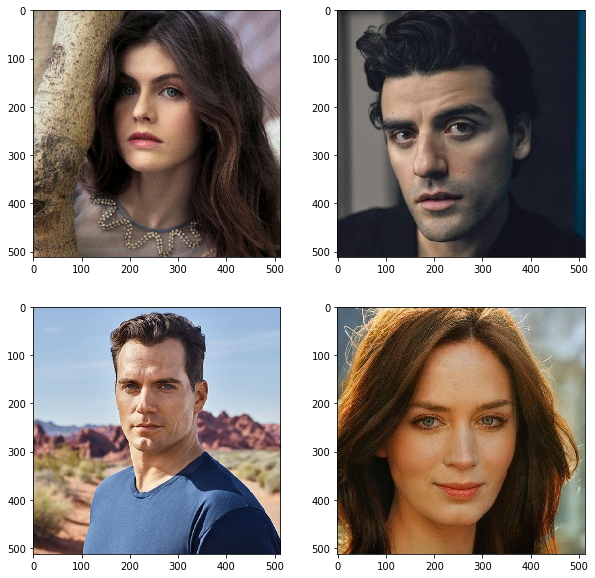

In [18]:
# Imágenes del conjunto de entrenamiento

im1 = plt.imread("images/alexandra.jpg")
im2 = plt.imread("images/oscar.jpeg")
im3 = plt.imread("images/henry.jpeg")
im4 = plt.imread("images/emily.jpg")

_, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

imagenes = [im1, im2, im3, im4]

print("Algunas de las imágenes que se usan en la construcción de la matriz de transformación:")

for img, ax in zip(imagenes, axs):
    ax.imshow(img)
    
plt.show()

Imágenes que se usan en para la prueba:


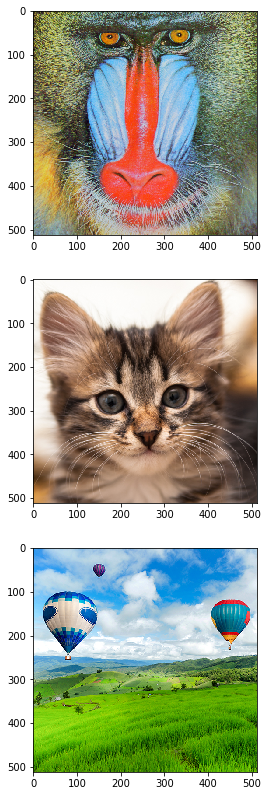

In [19]:
# Imágenes del conjunto de prueba

im1 = plt.imread("images/baboon.png")
im2 = plt.imread("images/cat.png")
im3 = plt.imread("images/paisaje.png")

_, axs = plt.subplots(3, 1, figsize=(14, 14))
axs = axs.flatten()

imagenes = [im1, im2, im3]

print("Imágenes que se usan en para la prueba:")

for img, ax in zip(imagenes, axs):
    ax.imshow(img)
    
plt.show()

Ejemplos de parches de tamaño 32x32 para la primer imagen:


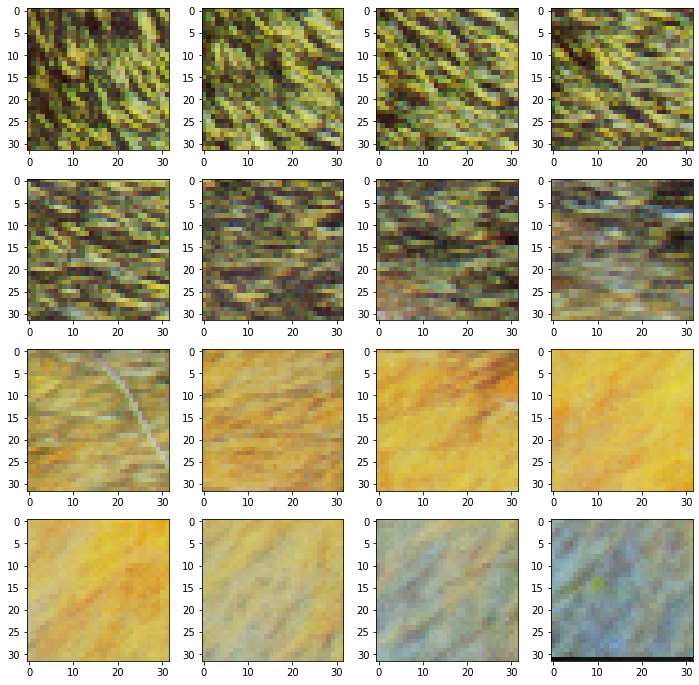

In [20]:
m = 1000
l = [16, 32]
theta = [0.9, 0.96, 0.98, 0.99]

# Para ilustrar los parches que se obtienen
R, G, B, coords = crop_equal(im1, l[1], l[1])

# Mostraremos solo 16 parches
parches_ejemplo = []
for i in range(16):
    parches_ejemplo.append(np.dstack((R[i], G[i], B[i])))


print("Ejemplos de parches de tamaño 32x32 para la primer imagen:")
    
    
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()

for img, ax in zip(parches_ejemplo, axs):
    ax.imshow(img)
    
plt.show()

Solo para ilustrar, mostraremos parches de mayor tamaño, aunque para la tarea se siguen usando los de tamaño 32

Ejemplos de parches de tamaño 128x128 para la primer imagen:


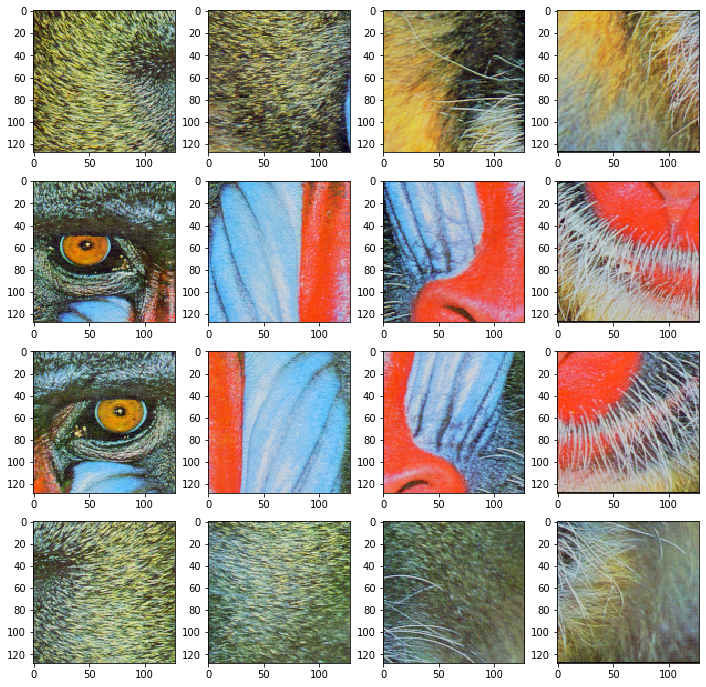

In [21]:
# Para ilustrar los parches que se obtienen
R, G, B, coords = crop_equal(im1, 128, 128)

# Mostraremos solo 16 parches
parches_ejemplo = []
for i in range(16):
    parches_ejemplo.append(np.dstack((R[i], G[i], B[i])))
    
    
print("Ejemplos de parches de tamaño 128x128 para la primer imagen:")

_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()

for img, ax in zip(parches_ejemplo, axs):
    ax.imshow(img)
    
plt.show()

Ilustramos ahora la compresión para diferentes valores de $\theta$ usando el tamaño de parche $l = 32$. Se imprimen las matrices de transofrmación y proyección, al mismo tiempo que el número de eigenvectores empleados.

Notaremos que, en general, se necesitan pocos eigenvectores para conseguir un valor alto de varianza a conservar, mientras más varianza se quiera, más eigenvectores. Imprimimos los datos solo para la primer imagen, ya que para las otras se hace de forma similar.


Matriz de covarianza:

[[5737369.  5707984.5 5666924.  ... 4300547.5 4267502.5 4253980. ]
 [5707984.5 5757082.5 5725096.5 ... 4333992.  4303211.5 4293538. ]
 [5666924.  5725096.5 5765958.  ... 4358681.  4325890.5 4314444. ]
 ...
 [4300547.5 4333992.  4358681.  ... 5542909.5 5500642.5 5453217.5]
 [4267502.5 4303211.5 4325890.5 ... 5500642.5 5530610.5 5492105.5]
 [4253980.  4293538.  4314444.  ... 5453217.5 5492105.5 5545960. ]]

Cantidad de eigenvectores tomados:

4

Matriz de transformación:

[[ 0.03   0.037 -0.047 -0.043  0.046]
 [ 0.03   0.035 -0.049 -0.042  0.048]
 [ 0.03   0.034 -0.05  -0.042  0.051]
 ...
 [ 0.03  -0.032  0.048 -0.035  0.044]
 [ 0.029 -0.034  0.046 -0.039  0.044]
 [ 0.029 -0.036  0.045 -0.042  0.045]]

Datos proyectados para canal R:

[[13.684 -2.018  0.505 -0.444  0.434]
 [15.35  -1.324  0.826 -0.265 -0.736]
 [15.823 -1.066  0.098 -0.366  0.337]
 ...
 [15.733 -0.371 -0.32  -0.291 -0.286]
 [14.447  0.084 -0.256 -0.176 -0.127]
 [11.844  0.195 -1.448 -0.053  0.067]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


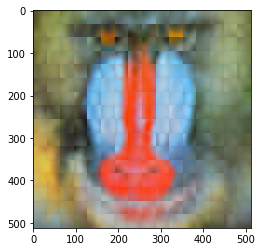

In [22]:
# Para theta = 0.96

X, U = mat_trans(Images, m, l[1], theta[1])
im_c = compresion(im1, l[1], U, [512, 512])
plt.imshow(im_c)


Matriz de covarianza:

[[5886306.5 5830270.5 5748524.5 ... 4300360.5 4287558.5 4248666. ]
 [5830270.5 5861114.  5796704.  ... 4302846.  4291627.5 4250922.5]
 [5748524.5 5796704.  5822461.5 ... 4297853.  4286331.  4243501. ]
 ...
 [4300360.5 4302846.  4297853.  ... 5799664.5 5747292.5 5702799. ]
 [4287558.5 4291627.5 4286331.  ... 5747292.5 5786581.5 5746102. ]
 [4248666.  4250922.5 4243501.  ... 5702799.  5746102.  5776022. ]]

Cantidad de eigenvectores tomados:

13

Matriz de transformación:

[[ 0.03   0.046 -0.036 ...  0.014 -0.04   0.033]
 [ 0.03   0.044 -0.038 ...  0.027 -0.038  0.029]
 [ 0.03   0.043 -0.039 ...  0.025 -0.038  0.027]
 ...
 [ 0.03  -0.04   0.037 ...  0.016 -0.038  0.059]
 [ 0.03  -0.041  0.035 ... -0.002 -0.032  0.058]
 [ 0.03  -0.042  0.034 ... -0.014 -0.026  0.061]]

Datos proyectados para canal R:

[[13.699 -1.996  0.149 ...  0.292  0.506 -0.071]
 [15.353 -1.325  0.463 ...  0.475  0.669 -0.968]
 [15.833 -0.989 -0.099 ... -0.588 -0.362  0.127]
 ...
 [15.736 -0.18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


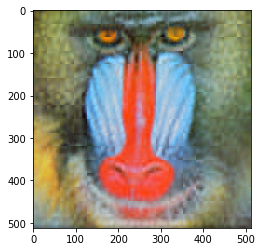

In [23]:
# Para theta = 0.98

X, U = mat_trans(Images, m, l[1], theta[2])
im_c = compresion(im1, l[1], U, [512, 512])
plt.imshow(im_c)


Matriz de covarianza:

[[5769010.  5732579.  5673618.  ... 4281232.5 4266030.  4229639. ]
 [5732579.  5817944.5 5772722.5 ... 4327997.  4313973.5 4273111.5]
 [5673618.  5772722.5 5819582.  ... 4352426.  4341240.  4300117. ]
 ...
 [4281232.5 4327997.  4352426.  ... 5652734.  5613079.  5573701. ]
 [4266030.  4313973.5 4341240.  ... 5613079.  5666973.  5633831. ]
 [4229639.  4273111.5 4300117.  ... 5573701.  5633831.  5673739. ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Cantidad de eigenvectores tomados:

44

Matriz de transformación:

[[ 0.03   0.041 -0.042 ... -0.003  0.047  0.101]
 [ 0.03   0.039 -0.043 ... -0.014  0.05   0.068]
 [ 0.03   0.037 -0.044 ... -0.042  0.064  0.038]
 ...
 [ 0.03  -0.033  0.04  ... -0.009 -0.007 -0.018]
 [ 0.03  -0.034  0.04  ... -0.029 -0.052  0.019]
 [ 0.03  -0.035  0.04  ... -0.047 -0.077  0.013]]

Datos proyectados para canal R:

[[13.691 -1.988  0.482 ...  0.168  0.397 -0.308]
 [15.351 -1.256  0.71  ... -0.625  0.325 -0.491]
 [15.827 -1.063  0.026 ...  0.078 -0.031 -0.097]
 ...
 [15.734 -0.34  -0.388 ... -0.138 -0.015  0.043]
 [14.448  0.105 -0.314 ...  0.022  0.075  0.049]
 [11.839  0.221 -1.454 ... -0.123 -0.157  0.03 ]]

Datos proyectados para canal G:

[[13.237 -2.588  0.85  ...  0.076  0.187 -0.294]
 [15.337 -1.451  0.733 ... -0.694  0.313 -0.544]
 [15.688 -1.341  0.221 ...  0.055  0.089 -0.14 ]
 ...
 [17.931 -0.688 -0.329 ... -0.124 -0.017  0.052]
 [16.368 -0.22  -0.752 ...  0.108  0.184  0.103]
 [11.994  0.25

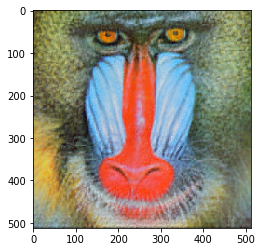

In [24]:
# Para theta = 0.99

X, U = mat_trans(Images, m, l[1], theta[3])
im1_c = compresion(im1, l[1], U, [512, 512])
plt.imshow(im1_c)

Ilustramos lo anterior ahora para un tamaño de parche $l = 16$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


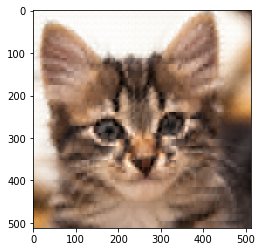

In [25]:
# Para theta = 0.98

X, U = mat_trans(Images, m, l[0], theta[2], Print = False)
im_c = compresion(im2, l[0], U, [512, 512], Print = False)
plt.imshow(im_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


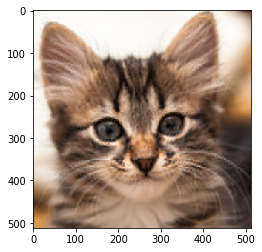

In [26]:
# Para theta = 0.99

X, U = mat_trans(Images, m, l[0], theta[3], Print = False)
im2_c = compresion(im2, l[0], U, [512, 512], Print = False)
plt.imshow(im2_c)

Para la última ronda de prueba ilustremos qué pasa cuando añadimos más parches a las imágenes. Se compara la imagen para parches $m = 1000$ y $m = 10000$. Visualmente hay una mejora.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


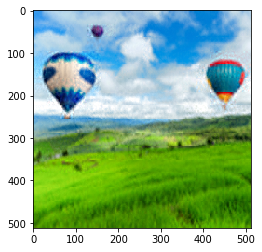

In [27]:
# Para theta = 0.99, l = 32

X, U = mat_trans(Images, m, l[1], theta[3], Print = False)
im_c = compresion(im3, l[1], U, [512, 512], Print = False)
plt.imshow(im_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


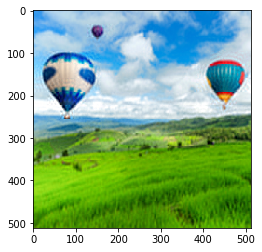

In [28]:
m = 10000

# Para theta = 0.99, l = 32

X, U = mat_trans(Images, m, l[1], theta[3], Print = False)
im_c = compresion(im3, l[1], U, [512, 512], Print = False)
plt.imshow(im_c)

## Error MAE

En esta sección se calcula el error MAE para diferentes valores de $\theta$, $l$ y $m$.

En este caso $\{J\}$ es el conjunto de imágenes de prueba, $J_i(p)$ es la el valor de la imagen $J_i$ en el pixel con posición $p$, y $\hat{J_i}$ es la reconstrucción de la imagen $J_i$. El error MAE estará dado por:

$$MAE_{\theta} = \frac{1}{N} \sum_{i=1}^N \sum_{p} |J_i^{\theta}(p)-\hat{J_i}^{\theta}(p)|.$$

In [29]:
# Función para calcular el error MAE

def MAE(J, J_t):
    '''Calcula el error MAE entre dos imaǵenes
    '''
    dim1, dim2, canales = J.shape
    
    mae = np.sum(np.abs(J - J_t))
    
    return mae/(canales*dim1*dim2) # Tomamos el promedio del error entre canales

In [30]:
# Probamos con diferentes valores de theta para generar la gráfica MAE
# En este primer caso consideramos l = 16, m = 1000

theta = np.linspace(0.9,.99,10)
Error1 = []
n = len(imagenes)
for t in theta:
    mae = 0
    for imagen in imagenes:
        X, U = mat_trans(Images, 1000, l[0], t, Print = False)
        imagene_c = compresion(imagen, l[0], U, [512, 512], Print = False)
        mae += MAE(imagen, imagene_c)
    Error1.append(mae/n)
    
print("Valores de theta:", theta)
print("l:", l[0])
print("m:", 1000)
print("Valores MAE:", Error1)

Valores de theta: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
l: 16
m: 1000
Valores MAE: [0.06886312964423191, 0.06888817657310663, 0.06893128610866679, 0.0687591543520846, 0.06713842706640084, 0.061975602756022964, 0.06138805234528697, 0.05361516043764394, 0.049606914418917826, 0.04138311239308425]


In [31]:
Error2 = []

for t in theta:
    mae = 0
    for imagen in imagenes:
        X, U = mat_trans(Images, 1000, l[1], t, Print = False)
        imagene_c = compresion(imagen, l[1], U, [512, 512], Print = False)
        mae += MAE(imagen, imagene_c)
    Error2.append(mae/n)
    
print("Valores de theta:", theta)
print("l:", l[1])
print("m:", 1000)
print("Valores MAE:", Error2)

Valores de theta: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
l: 32
m: 1000
Valores MAE: [0.07935500036397163, 0.07951893205304643, 0.07453943496302871, 0.06886316493064895, 0.06892381692744838, 0.06720571809733687, 0.06309791010799838, 0.05764845398224256, 0.051026133189599344, 0.04362101776140032]


In [32]:
Error3 = []

for t in theta:
    mae = 0
    for imagen in imagenes:
        X, U = mat_trans(Images, 10000, l[0], t, Print = False)
        imagene_c = compresion(imagen, l[0], U, [512, 512], Print = False)
        mae += MAE(imagen, imagene_c)
    Error3.append(mae/n)
    
print("Valores de theta:", theta)
print("l:", l[0])
print("m:", 10000)
print("Valores MAE:", Error3)

Valores de theta: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
l: 16
m: 10000
Valores MAE: [0.0687818888686496, 0.06878229715479972, 0.06877683827312728, 0.06875939110273831, 0.06876562782751026, 0.061884695768001645, 0.06188323522561092, 0.05331376152830628, 0.048395566125506106, 0.03889737226175534]


In [33]:
Error4 = []

for t in theta:
    mae = 0
    for imagen in imagenes:
        X, U = mat_trans(Images, 10000, l[1], t, Print = False)
        imagene_c = compresion(imagen, l[1], U, [512, 512], Print = False)
        mae += MAE(imagen, imagene_c)
    Error4.append(mae/n)
    
print("Valores de theta:", theta)
print("l:", l[1])
print("m:", 10000)
print("Valores MAE:", Error4)

Valores de theta: [0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
l: 32
m: 10000
Valores MAE: [0.07943825489757829, 0.07944906605496738, 0.07939382854826926, 0.06864895905093556, 0.06865314837155832, 0.06873978984126244, 0.06194445469667889, 0.05696200914090362, 0.049477857712653374, 0.04033240703761893]


Proseguimos con las gráficas para el MAE, se comparan de acuerdo al número de parches. Podemos notar de lo anterior que los errores no difieren mucho, por lo que en la gráfica se verán como si estuvieran sobrelapados. Al final se muestra qué error es mayor.

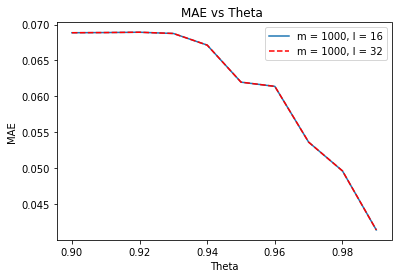

In [34]:
plt.plot(theta, Error1, label = "m = 1000, l = 16") 
plt.plot(theta, Error1, label = "m = 1000, l = 32", linestyle='dashed', color = "red") 

plt.xlabel('Theta') 

plt.ylabel('MAE') 
  
plt.title('MAE vs Theta ') 

plt.legend()
  
plt.show() 

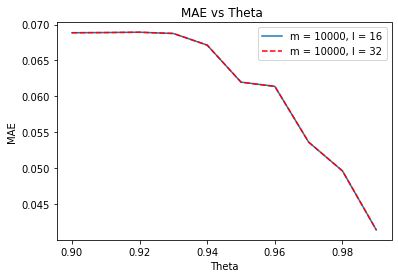

In [35]:
plt.plot(theta, Error1, label = "m = 10000, l = 16") 
plt.plot(theta, Error1, label = "m = 10000, l = 32", linestyle='dashed', color = "red") 

plt.xlabel('Theta') 

plt.ylabel('MAE') 
  
plt.title('MAE vs Theta ') 

plt.legend()
  
plt.show() 

In [36]:
print("Valores de theta para los cuales error de m=1000, l=32 es más grande que el de l=16\n")

for i in range(len(theta)):
    if Error2[i] > Error1[i]:
        print("Con parches de tamaño 32 el error es más para una varianza de", theta[i])
    

Valores de theta para los cuales error de m=1000, l=32 es más grande que el de l=16

Con parches de tamaño 32 el error es más para una varianza de 0.9
Con parches de tamaño 32 el error es más para una varianza de 0.91
Con parches de tamaño 32 el error es más para una varianza de 0.92
Con parches de tamaño 32 el error es más para una varianza de 0.93
Con parches de tamaño 32 el error es más para una varianza de 0.9400000000000001
Con parches de tamaño 32 el error es más para una varianza de 0.95
Con parches de tamaño 32 el error es más para una varianza de 0.96
Con parches de tamaño 32 el error es más para una varianza de 0.97
Con parches de tamaño 32 el error es más para una varianza de 0.98
Con parches de tamaño 32 el error es más para una varianza de 0.99


In [37]:
print("Valores de theta para los cuales error de m=10000, l=32 es más grande que el de l=16\n")

for i in range(len(theta)):
    if Error4[i] > Error3[i]:
        print("Con parches de tamaño 32 el error es más grande para una varianza de", theta[i])
    

Valores de theta para los cuales error de m=10000, l=32 es más grande que el de l=16

Con parches de tamaño 32 el error es más grande para una varianza de 0.9
Con parches de tamaño 32 el error es más grande para una varianza de 0.91
Con parches de tamaño 32 el error es más grande para una varianza de 0.92
Con parches de tamaño 32 el error es más grande para una varianza de 0.95
Con parches de tamaño 32 el error es más grande para una varianza de 0.96
Con parches de tamaño 32 el error es más grande para una varianza de 0.97
Con parches de tamaño 32 el error es más grande para una varianza de 0.98
Con parches de tamaño 32 el error es más grande para una varianza de 0.99


## Observaciones finales

1. Lo primero que podemos hacer es una nota en general sobre el compresor. Éste funciona bien con imágenes en formato png pero no en jpg o jpeg por el tipo de compresión previa que tienen.

2. No se necesitan muchos eigenvectores para conservar una varianza grande, pudimos ver que para un valor de $\theta$ de 0.99 necesitamos entre 30 y 50 eigenvectores, y aún así logramos un buen nivel de compresión.

3. A pesar de que las imágenes usadas para construir la matriz de proyección no tienen nada que ver con las imágenes de prueba, la compresión se hace de forma correcta, ¿Por qué? Porque los eigenvectores que guardan caracterísiticas mas específicas de las imágenes son descartados al considerar una varianza $\theta$ máxima. 

4. En este trabajo usamos datos centrados pero no normalizados, por lo que en algunos casos de imágenes para conservar una varianza de 0.9 era necesario usar solo un eigenvector. Nuestra hipótesis es que quizá de tener datos centralizados hubiéramos usado más.

5. Se nota una mejora ligera al disminuir el tamaño de los parches, o aumentar la cantidad de ellos, pero no es un valor significante al comparar los MAE para cada caso, aunque en la imagen del paisaje se puede apreciar la diferencia entre una compresión y la otra.

6. Lo que sí vemos es que el error disminuye de forma significativa al aumentar la varianza a consevar, como era de esperarse. Como se mencionó antes no hacen falta muchos eigenvectores para proyectar los datos para conseguir buenos resultados con la compresión.